In [1]:
import pandas as pd
import torch.nn as nn
import numpy as np
import torch

df_train = pd.read_csv('./train_data.csv')
df_test = pd.read_csv('./test_data.csv')

device = torch.device("cuda")


In [2]:
df_train.describe()

,SalePrice,YearBuilt,Size(sqf),Floor,N_Parkinglot(Ground),N_Parkinglot(Basement),N_manager,N_elevators,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
count,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000
mean,222177.477207,2002.977934,959.958778,11.994665,192.789040,572.857662,6.313773,11.055771,5.824200,9.860330,10.872696
std,106325.535526,8.765838,384.548456,7.581330,215.455916,408.179957,3.224556,7.717030,2.344331,3.444848,4.427445
min,34070.000000,1978.000000,135.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
25%,144752.000000,1993.000000,644.000000,6.000000,11.000000,184.000000,5.000000,5.000000,4.000000,8.000000,7.000000
50%,209588.000000,2006.000000,910.000000,11.000000,100.000000,536.000000,6.000000,11.000000,5.000000,9.000000,10.000000
75%,291570.000000,2007.000000,1160.000000,17.000000,249.000000,798.000000,8.000000,16.000000,7.000000,13.000000,15.000000
max,585840.000000,2015.000000,2337.000000,43.000000,713.000000,1321.000000,14.000000,27.000000,10.000000,16.000000,17.000000


In [3]:
df_train["SalePrice"].value_counts()

149274    38
75920     38
176991    38
265486    36
230088    35
          ..
227876     1
194247     1
328318     1
76106      1
557522     1
Name: SalePrice, Length: 841, dtype: int64

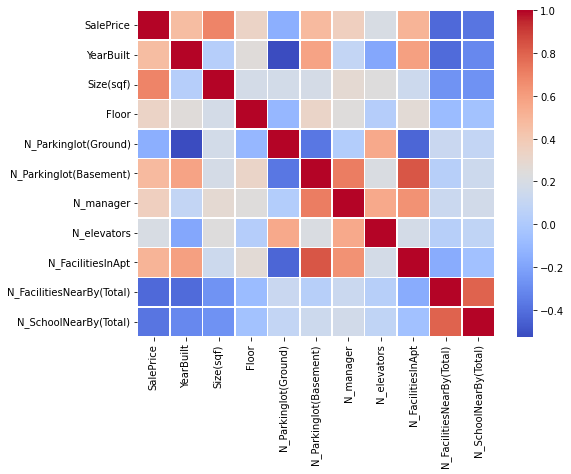

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

corr = df_train.corr()
sns.heatmap(corr, linewidth=.5, cmap=sns.color_palette('coolwarm', as_cmap=True))

plt.show()

# Mapowanie kolumn obiektowych na One Hot

## Kategoryzacja outputu

 > < 100 000 - Cheap - 0

 > 100 000 < x < 350 000 - Average - 1
 
 > 350 000 - Expensive - 2

In [5]:
bins = [0, 100_000, 350_000, np.inf]
categories = [0, 1, 2]

df_train['SalePrice'] = pd.cut(df_train['SalePrice'], bins, labels=categories)

In [6]:
df_train['SalePrice'].value_counts()

1    2992
2     570
0     562
Name: SalePrice, dtype: int64

## Mapowanie innych kolumn

In [7]:
columns_for_oneHot = []

for column, type in zip(df_train.columns, df_train.dtypes):
    if type == 'object':
        columns_for_oneHot.append(column)

df_train = pd.get_dummies(df_train, columns=columns_for_oneHot)
df_test = pd.get_dummies(df_test, columns=columns_for_oneHot)
        

### Upewnienie sie, że żadna kolumna ze zbioru walidacyjnego nie została pominięta

In [8]:
missing_cols = set( df_train.columns ) - set( df_test.columns )
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    if c != 'SalePrice':
        df_test[c] = 0

In [9]:
df_test.head()

,YearBuilt,Size(sqf),Floor,N_Parkinglot(Ground),N_Parkinglot(Basement),N_manager,N_elevators,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total),...,TimeToSubway_5min~10min,TimeToSubway_no_bus_stop_nearby,SubwayStation_Bangoge,SubwayStation_Banwoldang,SubwayStation_Chil-sung-market,SubwayStation_Daegu,SubwayStation_Kyungbuk_uni_hospital,SubwayStation_Myung-duk,SubwayStation_Sin-nam,SubwayStation_no_subway_nearby
0,1993,914,10,523.0,536.0,8.0,20.0,4,14.0,17.0,...,0,0,0,0,0,0,0,1,0,0
1,2014,907,16,90.0,1174.0,7.0,20.0,9,14.0,17.0,...,0,0,0,0,0,0,0,1,0,0
2,2007,1629,7,7.0,605.0,5.0,5.0,5,9.0,5.0,...,0,0,0,1,0,0,0,0,0,0
3,2005,743,21,67.0,798.0,6.0,0.0,7,13.0,15.0,...,1,0,1,0,0,0,0,0,0,0
4,2006,903,7,123.0,181.0,3.0,11.0,4,8.0,11.0,...,0,0,0,0,0,0,0,1,0,0


## Siec

### Wstepne przetwarzanie danych

In [10]:
train = df_train.sample(frac=0.8,random_state=200) #random state is a seed value
test = df_train.drop(train.index)

### Model

In [11]:
import torch.utils.data as data
import torch.optim as optim
import torch

In [12]:
class SimpleClassifier(nn.Module):

    def __init__(self, num_inputs, num_hidden1, num_hidden2, num_hidden3, num_outputs):
        super().__init__()
        # Initialize the modules we need to build the network
        self.lin1 = nn.Linear(num_inputs, num_hidden1)
        self.d1 = nn.Dropout(0.3)
        self.bn1 = nn.BatchNorm1d(num_hidden1)
        self.act1 = nn.ReLU()
        
        self.lin2 = nn.Linear(num_hidden1, num_hidden2)
        self.d2 = nn.Dropout(0.3)
        self.bn2 = nn.BatchNorm1d(num_hidden2)
        self.act2 = nn.ReLU()

        self.lin3 = nn.Linear(num_hidden2, num_hidden3)
        self.d3 = nn.Dropout(0.3)
        self.bn3 = nn.BatchNorm1d(num_hidden3)
        self.act3 = nn.ReLU()
        
        self.lin4 = nn.Linear(num_hidden3, num_outputs)

    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        x = self.lin1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.d1(x)
        
        x = self.lin2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.d2(x)

        x = self.lin3(x)
        x = self.bn3(x)
        x = self.act3(x)
        x = self.d3(x)
        
        x = self.lin4(x)
        
        return x

## Podzielenie zbiorów

In [13]:
X_train = train.drop(columns = ['SalePrice'])
Y_train = train['SalePrice']

X_test = test.drop(columns = ['SalePrice'])
Y_test = test['SalePrice']

In [14]:
train_dataset = data.TensorDataset(torch.from_numpy(np.array(X_train)), torch.tensor([[int(i == x) for i in range(3)] for x in Y_train]))
test_dataset = data.TensorDataset(torch.from_numpy(np.array(X_test)), torch.tensor([[int(i == x) for i in range(3)] for x in Y_test]))

In [15]:
train_data_loader = data.DataLoader(train_dataset, batch_size=256, shuffle=True)

### XGBoost dla uzyskania baseline'u

In [16]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

X_train_xgb, X_test_xgb, Y_train_xgb, Y_test_xgb = train_test_split(df_train.drop(columns = ['SalePrice']), df_train['SalePrice'], random_state=42)


In [ ]:
clf_xgb = xgb.XGBClassifier(learning_rate = 0.08, max_depth = 5, n_estimators = 100, missing=1, seed=42)
clf_xgb.fit(X_train_xgb, Y_train_xgb, verbose=True, early_stopping_rounds=100, eval_set=[(X_test_xgb, Y_test_xgb)])


In [18]:
result_train = clf_xgb.score(X_test_xgb, Y_test_xgb)
print("Accuracy : {}".format(result_train))

Accuracy : 0.8612997090203686


### Będziemy się starać uzyskać sieć neuronową przez pytorcha o accuracy zbliżonej do tej z XGBoosta

## Trenowanie

In [19]:
model = SimpleClassifier(X_train.columns.size, 1000, 750, 500, 3).to(device)
MSELoss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [20]:
model.train()

for epoch in range(300):  # loop over the dataset multiple times
    
    sum_loss = 0

    for inputs, labels in train_data_loader:
        # get the inputs; data is a list of [inputs, labels]

        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        preds = model(inputs.float())
        preds = torch.sigmoid(preds)
        loss = MSELoss(preds, labels.float())
        
        loss.backward()
        optimizer.step()

        sum_loss += loss
    
    print(epoch, sum_loss / X_train.shape[0])

0 tensor(0.0004, device='cuda:0', grad_fn=<DivBackward0>)
1 tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)
2 tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)
3 tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)
4 tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)
5 tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)
6 tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)
7 tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)
8 tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)
9 tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)
10 tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)
11 tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)
12 tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)
13 tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)
14 tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)
15 tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)
16 tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)
17 tens

## Walidacja

In [21]:
model.eval()
true_preds, num_preds = 0., 0.

with torch.no_grad(): # Deactivate gradients for the following code
    for data_inputs, data_labels in test_dataset:
        # Determine prediction of model on dev set
        data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
        preds = model(data_inputs.unsqueeze(dim=0).float())
        preds = torch.sigmoid(preds) # Sigmoid to map predictions between 0 and 1
        preds = preds.cpu()
        preds = preds.numpy()
        preds = preds.squeeze()

        preds = [int (x == max(preds)) for x in preds]

        # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
        data_labels = data_labels.cpu()
        true_preds += (np.argmax(preds)) == np.argmax(data_labels.numpy()).sum()
        num_preds += 1
        
acc = true_preds / num_preds
print(f"Accuracy of the model: {100.0*acc:4.2f}%")

Accuracy of the model: 87.03%


## Przewidywanie zbioru testowego

In [24]:
model.eval()

preds_map = {0: "cheap",
             1: "average",
             2: "expensive"}

all_preds = []

with torch.no_grad(): # Deactivate gradients for the following code
    for data_inputs in df_test.values:
        # data_inputs = data_inputs.cpu()
        preds = model(torch.tensor(data_inputs).unsqueeze(dim=0).float().to(device))
        preds = torch.sigmoid(preds) # Sigmoid to map predictions between 0 and 1
        preds = preds.cpu().numpy()
        preds = preds.squeeze()

        all_preds.append(preds_map.get(np.argmax(preds)))

pd.DataFrame(all_preds).to_csv("results.csv", index=False, header=None)